# GPT for Tabular Classification with SHAP Analysis

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import shap


2025-02-04 13:44:53.963084: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 13:44:53.982174: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 13:44:54.135295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 13:44:54.136148: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 13:44:54.732429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Step 1: Data Loading

In [2]:
# Define column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop the 'difficulty_degree' column
train.drop("difficulty_degree", axis=1, inplace=True)
test.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Convert labels to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert each row into a string format for tokenization (GPT needs text inputs)
train_sequences = [" ".join(map(str, row)) for row in X_train]
test_sequences = [" ".join(map(str, row)) for row in X_test]


In [3]:
# Load GPT-2 tokenizer and manually set padding token
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as padding token

# Tokenize dataset
train_encodings = tokenizer(train_sequences, truncation=True, padding=True, max_length=128, return_tensors="tf")
test_encodings = tokenizer(test_sequences, truncation=True, padding=True, max_length=128, return_tensors="tf")

# Convert labels to NumPy int32 arrays & reshape to 1D
y_train = np.array(y_train).astype(np.int32).reshape(-1)
y_test = np.array(y_test).astype(np.int32).reshape(-1)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(32)


2025-02-04 13:45:03.818251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 13:45:03.823844: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Load GPT-2 base model
from transformers import TFGPT2Model, AutoTokenizer
gpt2_model = TFGPT2Model.from_pretrained("gpt2")

# Define a custom model with a classification head
class GPT2IDSModel(tf.keras.Model):
    def __init__(self, gpt2_model):
        super(GPT2IDSModel, self).__init__()
        self.gpt2 = gpt2_model
        self.classifier = tf.keras.layers.Dense(2, activation="softmax")  # 2 classes (Normal, Attack)

    def call(self, inputs, training=False):
        gpt2_output = self.gpt2(inputs)[0]  # Extract GPT-2 embeddings
        pooled_output = tf.reduce_mean(gpt2_output, axis=1)  # Average pooling across tokens
        return self.classifier(pooled_output)

# Initialize the model
model = GPT2IDSModel(gpt2_model)


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# Train the model
print("Training GPT-2 Based IDS Model...")
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)


Training GPT-2 Based IDS Model...
Epoch 1/3
3937/3937 [==============================] - 14477s 4s/step - loss: 0.0557 - accuracy: 0.9818 - val_loss: 0.8707 - val_accuracy: 0.8125
Epoch 2/3
 542/3937 [===>..........................] - ETA: 3:18:49 - loss: 0.0307 - accuracy: 0.9916

In [19]:
# Evaluate on the test set
print("Evaluating GPT-2 Based IDS Model...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Evaluating GPT-2 Based IDS Model...
705/705 [==============================] - 829s 1s/step - loss: 0.7701 - accuracy: 0.8206
Test Loss: 0.770138144493103, Test Accuracy: 0.820573091506958


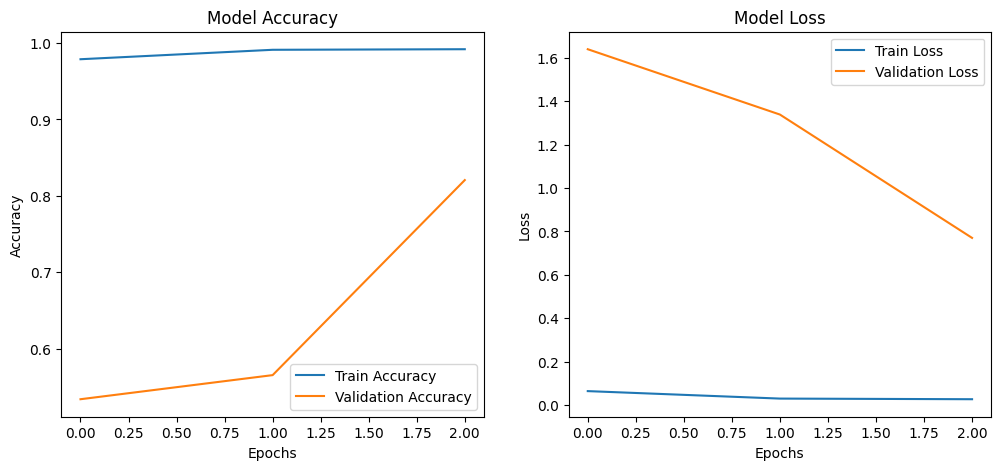

In [20]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


705/705 [==============================] - 917s 1s/step


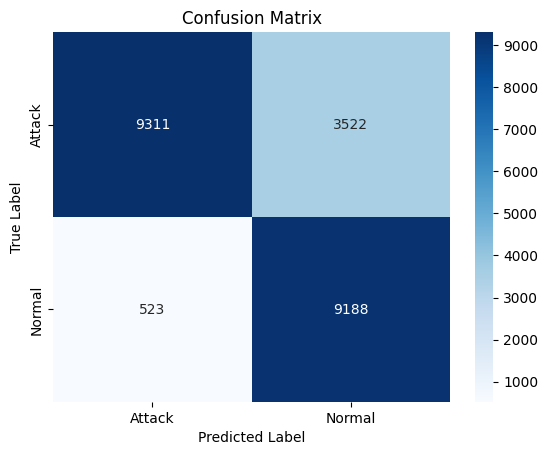

              precision    recall  f1-score   support

      Attack       0.95      0.73      0.82     12833
      Normal       0.72      0.95      0.82      9711

    accuracy                           0.82     22544
   macro avg       0.83      0.84      0.82     22544
weighted avg       0.85      0.82      0.82     22544



In [23]:
# Generate predictions
# Generate predictions
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("visualization/GPT2_Confusion-Matrix.png")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))


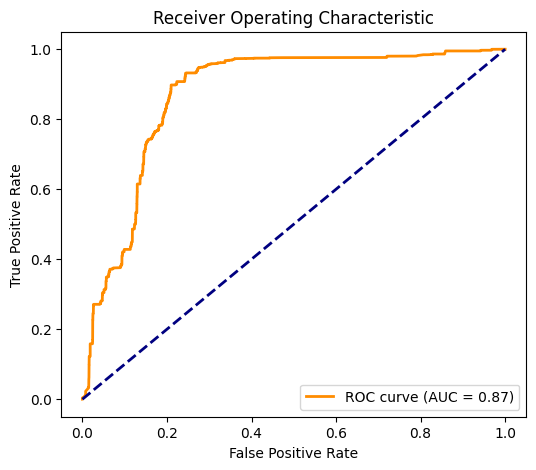

In [24]:
# Compute ROC Curve
y_pred_proba = y_pred_proba[:, 1]  # Probability for class 'Normal'
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("GPT2_ROC-Curve.png")
plt.show()


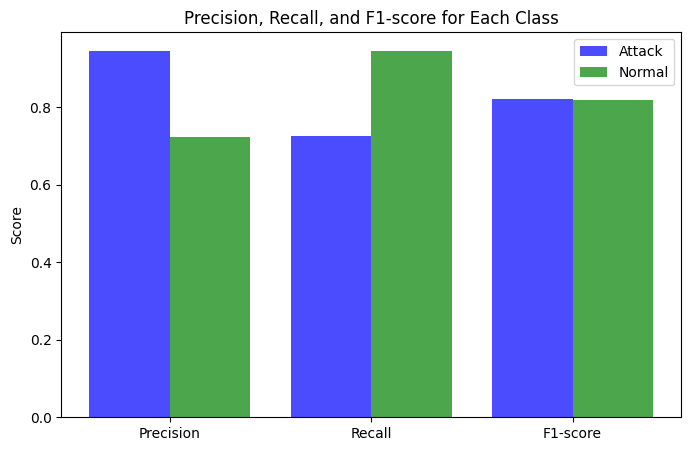

In [25]:
# Extract metrics from classification report
report_dict = classification_report(y_test, y_pred, target_names=["Attack", "Normal"], output_dict=True)

precision_attack = report_dict["Attack"]["precision"]
recall_attack = report_dict["Attack"]["recall"]
f1_attack = report_dict["Attack"]["f1-score"]

precision_normal = report_dict["Normal"]["precision"]
recall_normal = report_dict["Normal"]["recall"]
f1_normal = report_dict["Normal"]["f1-score"]

# Metrics Labels and Values
metrics = ["Precision", "Recall", "F1-score"]
attack_values = [precision_attack, recall_attack, f1_attack]
normal_values = [precision_normal, recall_normal, f1_normal]

x = np.arange(len(metrics))

# Plot Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, attack_values, width=0.4, label="Attack", color="blue", alpha=0.7)
plt.bar(x + 0.2, normal_values, width=0.4, label="Normal", color="green", alpha=0.7)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score for Each Class")
plt.legend()
plt.savefig("GPT2_Metrics.png")
plt.show()
